In [1]:
# pip install kagglehub

In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("birajsth/cats-and-dogs-filtered")

# print("Path to dataset files:", path)

In [3]:
import torch
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score

In [4]:
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [6]:
train_data = datasets.ImageFolder(r'data\cats-and-dogs-filtered\versions\1\cats_and_dogs_filtered', transform=transform_train)
test_data = datasets.ImageFolder(r'data\cats-and-dogs-filtered\versions\1\cats_and_dogs_filtered', transform=transform_val)

In [8]:
test_data

Dataset ImageFolder
    Number of datapoints: 3000
    Root location: data\cats-and-dogs-filtered\versions\1\cats_and_dogs_filtered
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [9]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle = True, pin_memory=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle = False, pin_memory=True, num_workers=0)

In [10]:
dataiter = iter(train_loader)

images, labels = next(dataiter)

In [11]:
images.shape

torch.Size([32, 3, 224, 224])

In [12]:
labels.shape

torch.Size([32])

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def show_imgs(imgs, labels):
    f, axes = plt.subplots(1, 10, figsize = (30, 5))
    for i, axis in enumerate(axes):
       img = np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0)))
       axis.imshow(img)
       axis.set_title(labels[i].numpy())
       axis.axis('off')
    plt.show()


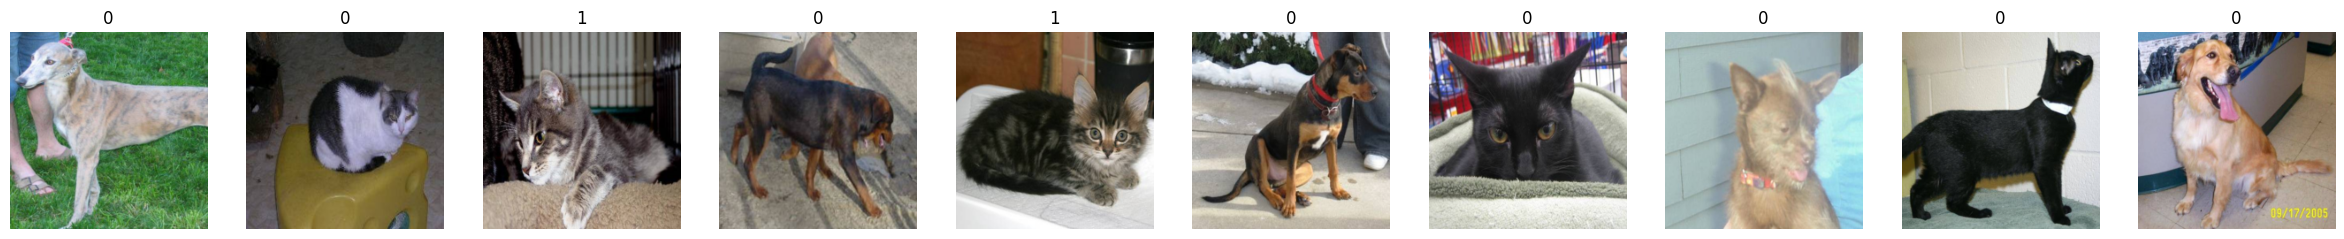

In [15]:
show_imgs(images, labels)

In [46]:
import torch.nn as nn
import torch.nn.functional as F
import tqdm.auto as tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
device

device(type='cuda')

In [48]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [56]:
def train(net, n_epoch=10):
    loss_fn = torch.nn.CrossEntropyLoss()
    
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    best_accuracy = 0
    for epoch in range(n_epoch):
        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(train_dataiter):
            X_batch, y_batch = batch
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_pred = net(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 500 == 499:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0
        with torch.no_grad():
            accuracy = []
            for batch in test_loader:
                x, y = batch
                x = x.to(device)
                y = y.to(device)
                y_pred = net(x)
                accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))

            accuracy = np.mean(np.array(accuracy))
            if accuracy > best_accuracy:
                    print('New best model with test acc:', accuracy)
                    torch.save(net.state_dict(), './best_model.pt')
                    best_accuracy = accuracy

    print("Обучение завершено")
    return net


In [57]:
model = nn.Sequential(
    Flatten(),
    nn.Linear(3*224*224, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 2),
).to(device)

In [58]:
torch.cuda.empty_cache()

import gc

gc.collect()

1390

In [59]:
model = train(model)

New best model with test acc: 0.6648936170212766
Обучение завершено


In [60]:
labels_net = []
labels_true = []
for images, labels in test_loader:
    labels_true.extend(labels)
    labels_net.extend(model.forward(images.cuda()).detach().cpu().numpy())

In [61]:
accuracy_score(labels_true, np.argmax(np.array(labels_net), axis=1))

0.6666666666666666